# Forcasting COVID-19 cases in the Philippines

## Importing dataset from Kaggle

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d antgoldbloom/covid19-data-from-john-hopkins-university

In [4]:
# from zipfile import ZipFile
# file_name = "/content/covid19-data-from-john-hopkins-university.zip"

# with ZipFile(file_name,"r") as zip:
# 	zip.extractall()
# 	print("Done")

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Load the dataset

Dataset can be downloaded in https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university

In [6]:
df= pd.read_csv('/content/CONVENIENT_global_confirmed_cases.csv')
print('Dataset shape:',df.shape)

Dataset shape: (372, 274)


In [7]:
df.head()

,Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia.1,Australia.2,Australia.3,Australia.4,Australia.5,Australia.6,Australia.7,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,...,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,United Kingdom.1,United Kingdom.2,United Kingdom.3,United Kingdom.4,United Kingdom.5,United Kingdom.6,United Kingdom.7,United Kingdom.8,United Kingdom.9,United Kingdom.10,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,Province/State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,New South Wales,Northern Territory,Queensland,South Australia,Tasmania,Victoria,Western Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anguilla,Bermuda,British Virgin Islands,Cayman Islands,Channel Islands,Falkland Islands (Malvinas),Gibraltar,Isle of Man,Montserrat,Turks and Caicos Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Preprocessing

* Retrieve covid-19 data for the Philippines
* Visualization
* Scaling

### Retrieve covid-19 data for the Philippines

In [8]:
# Dropping first row (Province/State)
ph_data = df[['Country/Region','Philippines']].rename(columns={'Country/Region':'Date'})[1:].reset_index(drop=True)
ph_data.head()

,Date,Philippines
0,1/23/20,0.0
1,1/24/20,0.0
2,1/25/20,0.0
3,1/26/20,0.0
4,1/27/20,0.0


In [9]:
ph_data.tail()

,Date,Philippines
366,1/23/21,1792.0
367,1/24/21,1940.0
368,1/25/21,1377.0
369,1/26/21,1170.0
370,1/27/21,2241.0


### Visualization

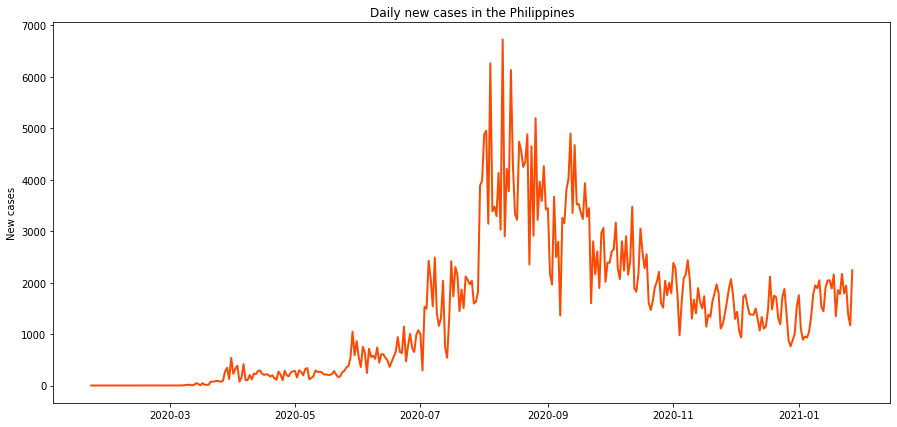

In [34]:
ph_data_copy = ph_data.copy()
ph_data_copy['Date'] = pd.to_datetime(ph_data_copy['Date'])

plt.figure(figsize=(15,7))
plt.title('Daily new cases in the Philippines')
plt.plot_date(ph_data_copy['Date'],ph_data_copy['Philippines'],color='#fc4a03',fmt='-',lw=2)
plt.ylabel('New cases')
plt.show()

### Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

# scales down your data between 0 and 1
scaler = MinMaxScaler()
# reshape data since scaler accepts 2d array
ph_data2 = scaler.fit_transform(np.array(ph_data['Philippines']).reshape(-1,1))
ph_data2[:20]

array([[0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.0001487],
       [0.       ],
       [0.       ],
       [0.0001487],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.0001487],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ]])

## Model Building

* Split the dataset into train and test dataset
* Build X and y values from train and test data
* Reshape X values
* Training the Model
* Model Evaluation
* Saving the model
* Forecasting

### Split the dataset into train and test dataset

In [12]:
dataset_length = len(ph_data2)
print(f'Dataset length: {dataset_length}')

# Since we are dealing with time-series data, we cant just split the data randomly
# First 80% of the data will be the training data and the remaining 20% for the testing data

training_data_length = int(dataset_length*0.8)
testing_data_length = dataset_length - training_data_length

print(f'\nTraining dataset length: {training_data_length}')
print(f'Testing dataset length: {testing_data_length}')

training_data = ph_data2[:training_data_length]
testing_data = ph_data2[training_data_length:]

print(f'\nTraining dataset shape: {training_data.shape}')
print(f'Testing dataset shape: {testing_data.shape}')

Dataset length: 371

Training dataset length: 296
Testing dataset length: 75

Training dataset shape: (296, 1)
Testing dataset shape: (75, 1)


### Build X and y values from train and test data

In [13]:
# Now we will build X and y values with X = values with len(timesteps), y = value of timesteps + 1
# Example: X = New cases in each day from Day 1 to Day 60, y = number of new cases in Day 61
# Next iteration will be new cases from Day 2 to Day 61, y = number of new cases in Day 62

def create_X_and_y(dataset, timesteps=1):
  X,y = [],[]
  dataset_length = len(dataset) # to predict the number of cases in the last day, first day will start in index [dataset_length - timesteps - 1]
  for i in range(dataset_length-timesteps):
    temp = dataset[i:i+timesteps,0] 
    X.append(temp)
    y.append(dataset[i+timesteps,0])
  return np.array(X), np.array(y)

In [14]:
# initializing timesteps = 60 days
timesteps = 60

X_train, y_train = create_X_and_y(training_data,timesteps)
X_test, y_test = create_X_and_y(testing_data,timesteps)

print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (236, 60)
y train shape: (236,)
X test shape: (15, 60)
y test shape: (15,)


### Reshape X values

In [15]:
# LSTM accepts inputs in shape [batch, timesteps, feature]
# Values in timesteps doesn't have feature representation other than itself hence feature dimension will be equal to 1

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

X train shape: (236, 60, 1)
X test shape: (15, 60, 1)


In [16]:
X_train[0]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0001487 ],
       [0.        ],
       [0.        ],
       [0.0001487 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0001487 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.0002974 ],
       [0.0001487 ],
       [0.0005948 ],
       [0.00148699],
       [0.001

### Training the Model

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM , Dense, Bidirectional

In [18]:
model = Sequential()

model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [19]:
history = model.fit(X_train,y_train,batch_size=32,epochs=150,validation_data=(X_test,y_test),verbose=1)

Epoch 1/150
8/8 [==============================] - 17s 532ms/step - loss: 0.0706 - val_loss: 0.0139
Epoch 2/150
8/8 [==============================] - 1s 101ms/step - loss: 0.0243 - val_loss: 0.0031
Epoch 3/150
8/8 [==============================] - 1s 104ms/step - loss: 0.0169 - val_loss: 0.0026
Epoch 4/150
8/8 [==============================] - 1s 105ms/step - loss: 0.0156 - val_loss: 0.0031
Epoch 5/150
8/8 [==============================] - 1s 103ms/step - loss: 0.0130 - val_loss: 0.0031
Epoch 6/150
8/8 [==============================] - 1s 109ms/step - loss: 0.0096 - val_loss: 0.0032
Epoch 7/150
8/8 [==============================] - 1s 105ms/step - loss: 0.0111 - val_loss: 0.0031
Epoch 8/150
8/8 [==============================] - 1s 105ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 9/150
8/8 [==============================] - 1s 107ms/step - loss: 0.0110 - val_loss: 0.0032
Epoch 10/150
8/8 [==============================] - 1s 106ms/step - loss: 0.0107 - val_loss: 0.0051
Epoch 11

### Model Evaluation

* Training loss per epoch
* Calculate root mean squared error
* Plot predictions in training and test data

#### Training loss per epoch

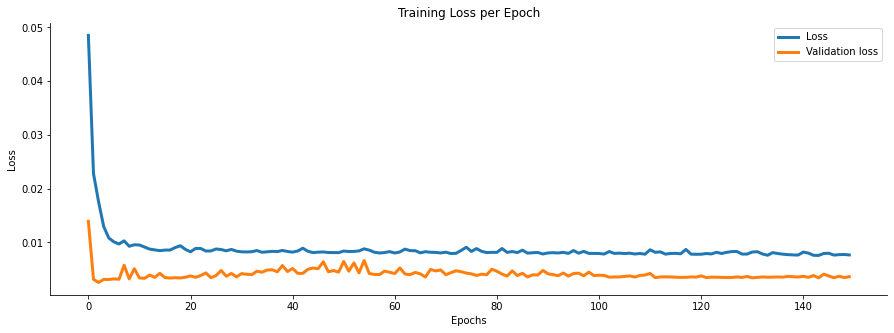

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,5))
plt.plot(loss,lw=3)
plt.plot(val_loss,lw=3)
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation loss'])
sns.despine()

#### Calculate root mean squared error

In [21]:
import math
from sklearn.metrics import mean_squared_error

In [22]:
# prediction for training and testing data
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

# inverse transform predicted and true y values for both training and testing data

y_train_predicted_scaled_back = scaler.inverse_transform(y_train_predicted) # predicted y train values
y_train_scaled_back = scaler.inverse_transform(y_train.reshape(-1, 1)) # truth y train values
y_test_predicted_scaled_back = scaler.inverse_transform(y_test_predicted) # predicted y test values
y_test_scaled_back = scaler.inverse_transform(y_test.reshape(-1, 1)) # truth y test values

# root mean squared error in training and test data

y_train_rmse = math.sqrt(mean_squared_error(y_train_scaled_back,y_train_predicted_scaled_back))
y_test_rmse = math.sqrt(mean_squared_error(y_test_scaled_back,y_test_predicted_scaled_back))

print(f'y train root mean squared error: {y_train_rmse}')
print(f'y test root mean squared error: {y_test_rmse}')

y train root mean squared error: 580.9383509803484
y test root mean squared error: 405.1845201555707


#### Plot predictions in training and test data

In [23]:
# shift predictions for 60 days(based on timesteps) in both training and testing data 
# since predictions start after first 60 days(based on timesteps)
shift = timesteps

# initializing plots for prediction
prediction_plot = np.empty(len(ph_data))
prediction_plot[:] = np.nan

# training data prediction
# training data length was initialized before
prediction_plot[shift:training_data_length] = y_train_predicted_scaled_back.reshape(-1)

# testing data prediction
prediction_plot[training_data_length+shift:] = y_test_predicted_scaled_back.reshape(-1)

# merge predicted values into philippine data

ph_data_with_predicted = ph_data_copy
ph_data_with_predicted['Predicted'] = prediction_plot

ph_data_with_predicted.head()

,Date,Philippines,Predicted
0,2020-01-23,0.0,NaN
1,2020-01-24,0.0,NaN
2,2020-01-25,0.0,NaN
3,2020-01-26,0.0,NaN
4,2020-01-27,0.0,NaN


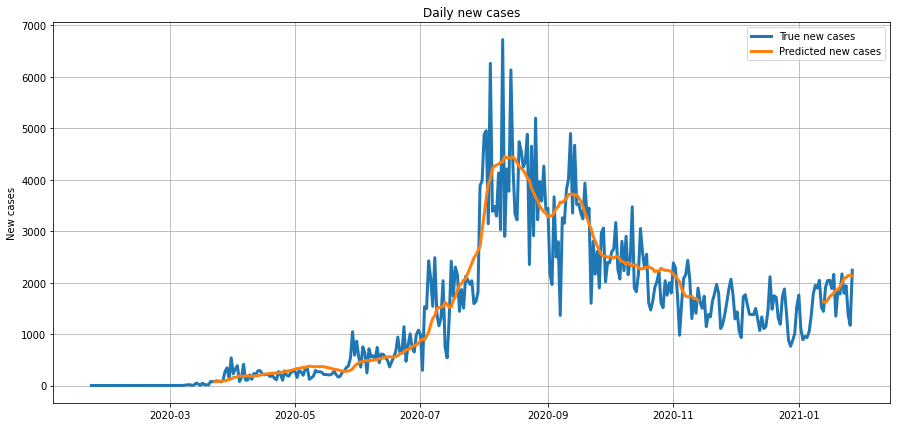

In [24]:
plt.figure(figsize=(15,7))
plt.title('Daily new cases')
plt.plot_date(ph_data_with_predicted['Date'],ph_data_with_predicted['Philippines'],fmt='-',lw=3)
plt.plot_date(ph_data_with_predicted['Date'],ph_data_with_predicted['Predicted'],fmt='-',lw=3)
plt.ylabel('New cases')
plt.legend(['True new cases', 'Predicted new cases'])
plt.grid()
plt.show()

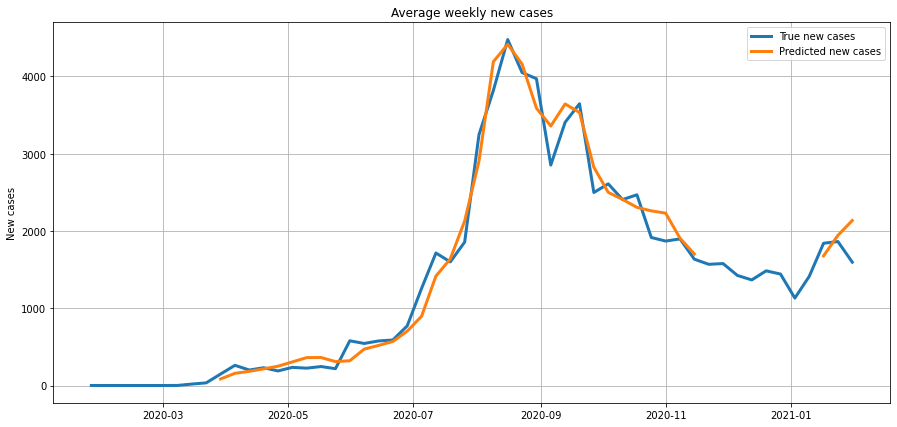

In [25]:
weekly_cases = ph_data_with_predicted.set_index('Date').resample('W').mean()
plt.figure(figsize=(15,7))
plt.title('Average weekly new cases')
plt.plot_date(weekly_cases.index,weekly_cases['Philippines'],fmt='-',lw=3)
plt.plot_date(weekly_cases.index,weekly_cases['Predicted'],fmt='-',lw=3)
plt.ylabel('New cases')
plt.legend(['True new cases', 'Predicted new cases'])
plt.grid()
plt.show()

### Saving the model

In [26]:
import pickle

model.save('forecasting_covid_19_ph_model.h5')
pickle.dump(scaler,open('scaler.pickle','wb'))

### Forecasting

* Retrieve new cases in the last 60 days
* Load saved model and scaler
* Forecast new cases in the future

#### Retrieve new cases in the last 60 days

In [27]:
import requests
import json

url = 'https://covid-api.mmediagroup.fr/v1/history?country=Philippines&status=confirmed'
x = requests.get(url)
loaded_ph_data = json.loads(x.text)['All']['dates']
dates = list(loaded_ph_data.keys())
cases = list(loaded_ph_data.values())

# the api gives updated total confirmed cases in each day
for date in dates[:5]:
  print('Date: ',date)
  print('Cases: ',loaded_ph_data[date])

Date:  2021-01-28
Cases:  519575
Date:  2021-01-27
Cases:  518407
Date:  2021-01-26
Cases:  516166
Date:  2021-01-25
Cases:  514996
Date:  2021-01-24
Cases:  513619


In [28]:
# get the number of new cases everyday
# note that dates and cases are reversed (index 0 gives the latest number of new cases)
today = np.array(cases[:-1])
yesterday = np.array(cases[1:])

# reversing the numpy array
new_cases = np.flip(today - yesterday)

cases_df = pd.DataFrame({'Date':dates[::-1][1:],'New cases':new_cases})
cases_df['Date'] = pd.to_datetime(cases_df['Date'])
cases_df.head()

,Date,New cases
0,2020-01-23,0
1,2020-01-24,0
2,2020-01-25,0
3,2020-01-26,0
4,2020-01-27,0


#### Load saved model and scaler

In [29]:
loaded_model = tf.keras.models.load_model('forecasting_covid_19_ph_model.h5')
loaded_scaler = pickle.load(open('scaler.pickle','rb'))

# retrieve and scale down the new cases in the last 60 days(timesteps required for prediction)
new_cases_60_days = loaded_scaler.transform(np.array(cases_df.tail(60)['New cases']).reshape(-1, 1))

#### Forecast new cases in the future

In [30]:
def forecast(days):
  future_predictions = []
  # reshaping into shape [batch, timesteps, feature]
  reshaped_new_cases_60_days = new_cases_60_days.reshape(1,60,1)
  for i in range(days):
    # predicts and adding prediction to list
    prediction = loaded_model.predict(reshaped_new_cases_60_days)
    future_predictions.append(max(0,prediction[0][0])) # applying max(0,prediction) to convert negative predictions to 0
    # appending prediction to new cases and updating new cases in the last 60 days
    reshaped_new_cases_60_days = np.append(reshaped_new_cases_60_days,prediction.reshape(1,1,1),axis=1)
    reshaped_new_cases_60_days = reshaped_new_cases_60_days[:,1:]
  return np.array(future_predictions)

In [36]:
from datetime import datetime

days_to_forecast = 30

# latest date in the covid data
latest_date = datetime.strptime(dates[0], '%Y-%m-%d').date()

# we include the latest date new cases in order to connect predicted new cases to current cases
prediction_dates = pd.date_range(latest_date,periods=days_to_forecast+1)
predicted_new_cases = loaded_scaler.inverse_transform(forecast(days_to_forecast).reshape(-1,1)).astype(int).reshape(-1)
# inserting new cases of the latest date
predicted_new_cases = np.insert(predicted_new_cases,0,np.array(cases_df.tail(1)['New cases']),axis=0)

prediction_df = pd.DataFrame({'Date':prediction_dates,'Predicted new cases':predicted_new_cases})
prediction_df

,Date,Predicted new cases
0,2021-01-28,1168
1,2021-01-29,2271
2,2021-01-30,2378
3,2021-01-31,2464
4,2021-02-01,2561
5,2021-02-02,2638
6,2021-02-03,2708
7,2021-02-04,2825
8,2021-02-05,2939
9,2021-02-06,3033


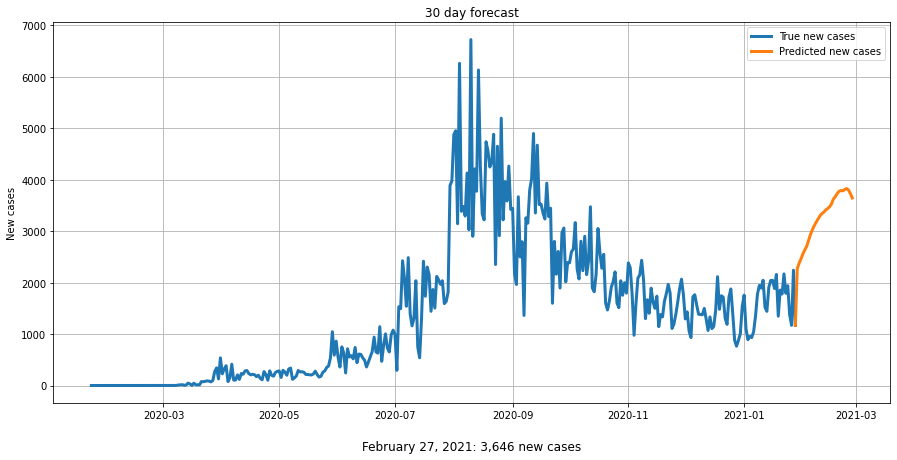

In [37]:
# prediction end date
last_row = prediction_df.tail(1)
last_date_prediction = last_row['Date'].dt.strftime('%B %d, %Y').values[0]
last_date_prediction_new_cases = last_row['Predicted new cases'].values[0]

plt.figure(figsize=(15,7))
plt.title('30 day forecast')
plt.plot_date(cases_df['Date'],cases_df['New cases'],fmt='-',lw=3)
plt.plot_date(prediction_df['Date'],prediction_df['Predicted new cases'],fmt='-',lw=3)
plt.legend(['True new cases', 'Predicted new cases'])
plt.xlabel(f'{last_date_prediction}: {last_date_prediction_new_cases:,} new cases',labelpad=20,fontdict={'fontsize':12})
plt.ylabel('New cases')
plt.grid()
plt.show()

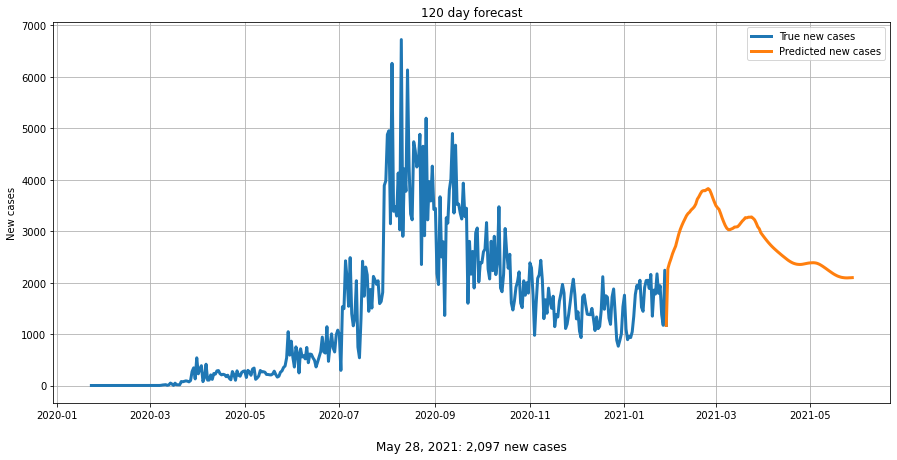

In [38]:
# forecast for 120 days
days_to_forecast = 120

# latest date in the covid data
latest_date = datetime.strptime(dates[0], '%Y-%m-%d').date()

# we include the latest date new cases in order to connect predicted new cases to current cases
prediction_dates = pd.date_range(latest_date,periods=days_to_forecast+1)
predicted_new_cases = loaded_scaler.inverse_transform(forecast(days_to_forecast).reshape(-1,1)).astype(int).reshape(-1)
# inserting new cases of the latest date
predicted_new_cases = np.insert(predicted_new_cases,0,np.array(cases_df.tail(1)['New cases']),axis=0)

prediction_df = pd.DataFrame({'Date':prediction_dates,'Predicted new cases':predicted_new_cases})

last_row = prediction_df.tail(1)
last_date_prediction = last_row['Date'].dt.strftime('%B %d, %Y').values[0]
last_date_prediction_new_cases = last_row['Predicted new cases'].values[0]

plt.figure(figsize=(15,7))
plt.title('120 day forecast')
plt.plot_date(cases_df['Date'],cases_df['New cases'],fmt='-',lw=3)
plt.plot_date(prediction_df['Date'],prediction_df['Predicted new cases'],fmt='-',lw=3)
plt.legend(['True new cases', 'Predicted new cases'])
plt.xlabel(f'{last_date_prediction}: {last_date_prediction_new_cases:,} new cases',labelpad=20,fontdict={'fontsize':12})
plt.ylabel('New cases')
plt.grid()
plt.show()